In [1]:
import sys
import pickle
sys.path.insert(0,'./')
import pyccl as ccl
import tracemalloc


# from importlib import reload

In [2]:
import dask
from distributed import LocalCluster
from dask.distributed import Client  # we already had this above
#http://distributed.readthedocs.io/en/latest/_modules/distributed/worker.html
LC=LocalCluster(n_workers=10,processes=False,memory_limit='50gb',threads_per_worker=1,memory_spill_fraction=.99,)
#                memory_monitor_interval='2000ms',worker_memory_limit='50gb')
client=Client(LC)
# dask.config.set(scheduler='single-threaded')

/usr/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [3]:
client

Client Scheduler: inproc://136.152.250.206/6189/1 Dashboard: http://localhost:8787/status,Cluster Workers: 10 Cores: 10 Memory: 500.00 GB


In [4]:
client.restart()

Client Scheduler: inproc://136.152.250.206/6189/1 Dashboard: http://localhost:8787/status,Cluster Workers: 10 Cores: 10 Memory: 500.00 GB


In [5]:
from cov_3X2 import *
# from fisher import *

In [6]:
#only for python3
import importlib
reload=importlib.reload

# Lensing X Lensing Correlation function covariance

## Multiple redshift bins (Tomography)

In [7]:
from lsst_utils import *

In [8]:
import cov_utils
reload(cov_utils)
from cov_utils import *

In [9]:
import window_utils
reload(window_utils)
from window_utils import *

In [10]:
import cov_3X2
reload(cov_3X2)
from cov_3X2 import *
from wigner_transform import *

In [11]:
import hankel_transform
from astropy.io import fits
reload(hankel_transform)
from hankel_transform import *


In [12]:
cosmo_params={'h': 0.8433,
 'Omb': 0.062,
 'Omd': 0.2837-0.062,
 's8': 0.795431,
 'Om': 0.2837,
 'As': 1.685e-09,
 'Ase9': 1.685,
 'mnu': 0.0,
 'Omk': 0.0,
 'tau': 0.06,
 'ns': 0.96859,
 'w': -1,
 'wa': 0,
 'Oml': 1.-0.2837}
PS=Power_Spectra(cosmo_params=cosmo_params)
k,pk,s8=PS.camb_pk(z=[0],cosmo_params=cosmo_params,return_s8=True)
s8

0.7971166457654738

In [13]:
mnu=cosmo_h.m_nu*0
cosmo=cosmo.clone(m_nu=mnu,Ob0=cosmo_params['Omb'],Om0=cosmo_params['Om'])
cosmo_h=cosmo.clone(H0=100) #,m_nu=mnu,Ob0=cosmo_params['Omb'],Om0=cosmo_params['Om'])
ccl_cosmo = ccl.Cosmology(Omega_c=cosmo_params['Omd'], Omega_b=cosmo_params['Omb'], 
                      h=cosmo_params['h'], A_s=cosmo_params['As'], n_s=cosmo_params['ns'],)#m_nu=[0,0,0.06])

In [14]:
use_window=True
do_sample_variance=True
SSV_cov=False
tidal_SSV=True
Tri_cov=False
sigma_gamma=0.3944/sqrt(2.)  #*2**0.25

In [15]:
f_sky=.7 #3000./(4*np.pi/d2r**2)
f_sky

nside=128

In [16]:
f_sky

0.7

In [17]:
zmin=0.3
zmax=2

z=np.linspace(0,5,200)
pzs=lsst_pz_source(z=z)
x=z<zmax
x*=z>zmin
z=z[x]
pzs=pzs[x]

ns0=26 #26+np.inf #ns=inf means shape noise is zero
nbins=1  # Number of tomographic bins
z_sigma=0.03
zs_bins=source_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,use_window=use_window,f_sky=f_sky,window_cl_fact=0,
                         ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),sigma_gamma=sigma_gamma,
                        zp_sigma=z_sigma*np.ones_like(z),nside=nside)

ng0=10 #26+np.inf #ns=inf means shape noise is zero
nlbins=1 # Number of tomographic bins
z_sigma=0.005
zl_bins=source_tomo_bins(zp=z,p_zp=pzs,ns=ng0,nz_bins=nlbins,use_window=use_window,f_sky=f_sky,
                         ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),window_cl_fact=0,
                        zp_sigma=z_sigma*np.ones_like(z),k_max=1.e6,nside=nside)
for i in np.arange(nlbins):
    zl_bins[i]['b1']=1

./cov_utils.py:60: RuntimeWarning: invalid value encountered in true_divide
  Win0=2*jn(1,l_th)/l_th
./angular_power_spectra.py:23: RuntimeWarning: divide by zero encountered in true_divide
  self.cl_f=(l+0.5)**2/(l*(l+1.)) # cl correction from Kilbinger+ 2017
/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


corr_indxs {('shear', 'shear'): [], ('galaxy', 'galaxy'): [(0, 0)], ('kappa', 'kappa'): []}
Win gen: step size 384
cl dict done


/usr/lib/python3.7/site-packages/healpy/sphtfunc.py:402: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
corr_indxs {('shear', 'shear'): [], ('galaxy', 'galaxy'): [(0, 0)], ('kappa', 'kappa'): []}
Win gen: step size 384
cl dict done
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [18]:
for a in ()+("X",):
    print (a)

X


In [19]:
do_cov=True

In [20]:
do_xi=True
bin_xi=True
bin_cl=True
th_min=2.5/60
th_max=250./60
n_th_bins=20
th_bins=np.logspace(np.log10(th_min),np.log10(th_max),n_th_bins+1)
th=np.logspace(np.log10(th_min*0.98),np.log10(1),n_th_bins*30)
th2=np.linspace(1,th_max*1.02,n_th_bins*30)
# th2=np.logspace(np.log10(1),np.log10(th_max),60*6)
th=np.unique(np.sort(np.append(th,th2)))
thb=np.sqrt(th_bins[1:]*th_bins[:-1])

In [21]:
#Hankel Transform setup
l_max=1e3
l_maxW=1e3
l_min=2
# nl=1e2
# nl_bins=np.int(nl/10)
# l0=np.logspace(np.log10(l_min),np.log10(l_maxW),nl)
# l0=np.append([0,1],l0)
# l0=np.unique(np.int32(l0))
# l0_HT=l0
l0=np.arange(l_min,l_max)
l0_HT=np.arange(l_max)
nl_bins=20
  #np.arange(l_min,l_max)
# l0=np.unique(np.int32(np.logspace(np.log10(l_min),np.log10(l_maxW),4.e3)))   #np.arange(l_min,l_max)
# l_bins=np.unique(np.int32(np.logspace(np.log10(l_min),np.log10(l_max),50)))
l_bins=np.unique(np.int32(np.linspace(l_min,l_max,nl_bins)))
prune_theta=0
HT_kwargs={'l_min':l_min,  'l_max':l_max,
                        'theta_min':th_min*d2r*.9, 'theta_max':th_max*d2r,
                        'n_zeros':40000, 'prune_theta':prune_theta, 'm1_m2':[(2,2),(2,-2),(0,2),(0,0)]}
# %time HT=hankel_transform(**HT_kwargs)
# HT_kwargs2={'l_min':l_min,  'l_max':l_max,
#                         'theta_min':th_min*d2r*.9, 'theta_max':th_max*d2r,
#                         'n_zeros':40000, 'prune_theta':2, 'm1_m2':[(2,-2)]}#,(2,-2)]}

In [22]:
power_spectra_kwargs={'cosmo':cosmo,'cosmo_params':cosmo_params,'pk_func':'camb_pk_too_many_z'}

In [23]:
corr_ggl=('shear','galaxy')
corr_ggk=('kappa','galaxy')
corr_gg=('galaxy','galaxy')
corr_ll=('shear','shear')
corr_kk=('kappa','kappa')
m1m2=(0,2)
m1m2_gg=(0,0)

In [24]:
#### Wigner Transform setup... Using high ell to test convergence
WT_L_kwargs={'l': l0_HT,'theta': th*d2r,'m1_m2':[(2,2),(2,-2),(0,2),(2,0),(0,0)]}
%time WT_L=wigner_transform(**WT_L_kwargs)

./wigner_functions.py:38: RuntimeWarning: invalid value encountered in true_divide
  d_mat/=np.sqrt(binom(k+b,b))
./wigner_functions.py:38: RuntimeWarning: divide by zero encountered in true_divide
  d_mat/=np.sqrt(binom(k+b,b))
./wigner_functions.py:38: RuntimeWarning: divide by zero encountered in true_divide
  d_mat/=np.sqrt(binom(k+b,b))


CPU times: user 934 ms, sys: 1.34 s, total: 2.27 s
Wall time: 6.11 s


In [25]:
window_lmax=30
bi=(0,0)



In [26]:
import window_utils
reload(window_utils)
from window_utils import *

import cov_utils
reload(cov_utils)
from cov_utils import *

import cov_3X2
reload(cov_3X2)
from cov_3X2 import *

In [27]:
do_cov=True
use_window=True

In [28]:
wigner_files={}
wigner_files[0]= 'temp/dask_wig3j_l6500_w2100_0_reorder.zarr'
wigner_files[2]= 'temp/dask_wig3j_l3500_w2100_2_reorder.zarr'

In [29]:
tracemalloc.clear_traces()
tracemalloc.start()

t1=time.time()
try:
    Win=XI_W_L.Win.Win
except:
    Win=None
XI_W_L= cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,zg_bins=zl_bins,
                do_sample_variance=do_sample_variance,use_window=use_window,window_lmax=window_lmax,
                power_spectra_kwargs=power_spectra_kwargs,corrs=[corr_ll,corr_gg,corr_ggl]
                ,store_win=True,Win=Win,
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,HT=WT_L,f_sky=f_sky,
               bin_xi=bin_xi,theta_bins=th_bins,
               wigner_files=wigner_files)#ns=np.inf)
t2=time.time()
snapshot1 = tracemalloc.take_snapshot()
print('W done',t2-t1)
top_stats = snapshot1.statistics('lineno')

corr_indxs {('shear', 'shear'): [(0, 0)], ('galaxy', 'galaxy'): [(0, 0)], ('kappa', 'kappa'): [], ('shear', 'galaxy'): [(0, 0)], ('galaxy', 'shear'): [(0, 0)]}
Win gen: step size 1001
wigner_files: {0: 'temp/dask_wig3j_l6500_w2100_0_reorder.zarr', 2: 'temp/dask_wig3j_l3500_w2100_2_reorder.zarr'}
wigner done dict_keys([0, 2])
setting windows <Client: scheduler='inproc://136.152.250.206/6189/1' processes=10 cores=10>
got window cls, now to coupling matrices.
done coupling submatrix  0 11.629404067993164 2.344050407409668
W done 25.51668119430542


In [30]:
top_stats = snapshot1.statistics('traceback')

In [31]:
tracemalloc.get_traced_memory()

(471851227, 2988898443)

In [32]:
stat = top_stats[0]
print("%s memory blocks: %.1f MiB" % (stat.count, stat.size / 1024**2))
for line in stat.traceback.format():
    print(line)

110 memory blocks: 312.8 MiB
  File "./window_utils.py", line 436
    result0['M'][corr_i][k][wp]=np.zeros((nl,nl))


In [33]:
%time clG=XI_W_L.cl_tomo()

added extra corr calc for covariance [('shear', 'shear'), ('galaxy', 'galaxy'), ('shear', 'galaxy'), ('galaxy', 'shear')]
Note: redshifts have been re-sorted (earliest first)
cl dict done
CPU times: user 3.49 s, sys: 26.8 ms, total: 3.52 s
Wall time: 1.48 s


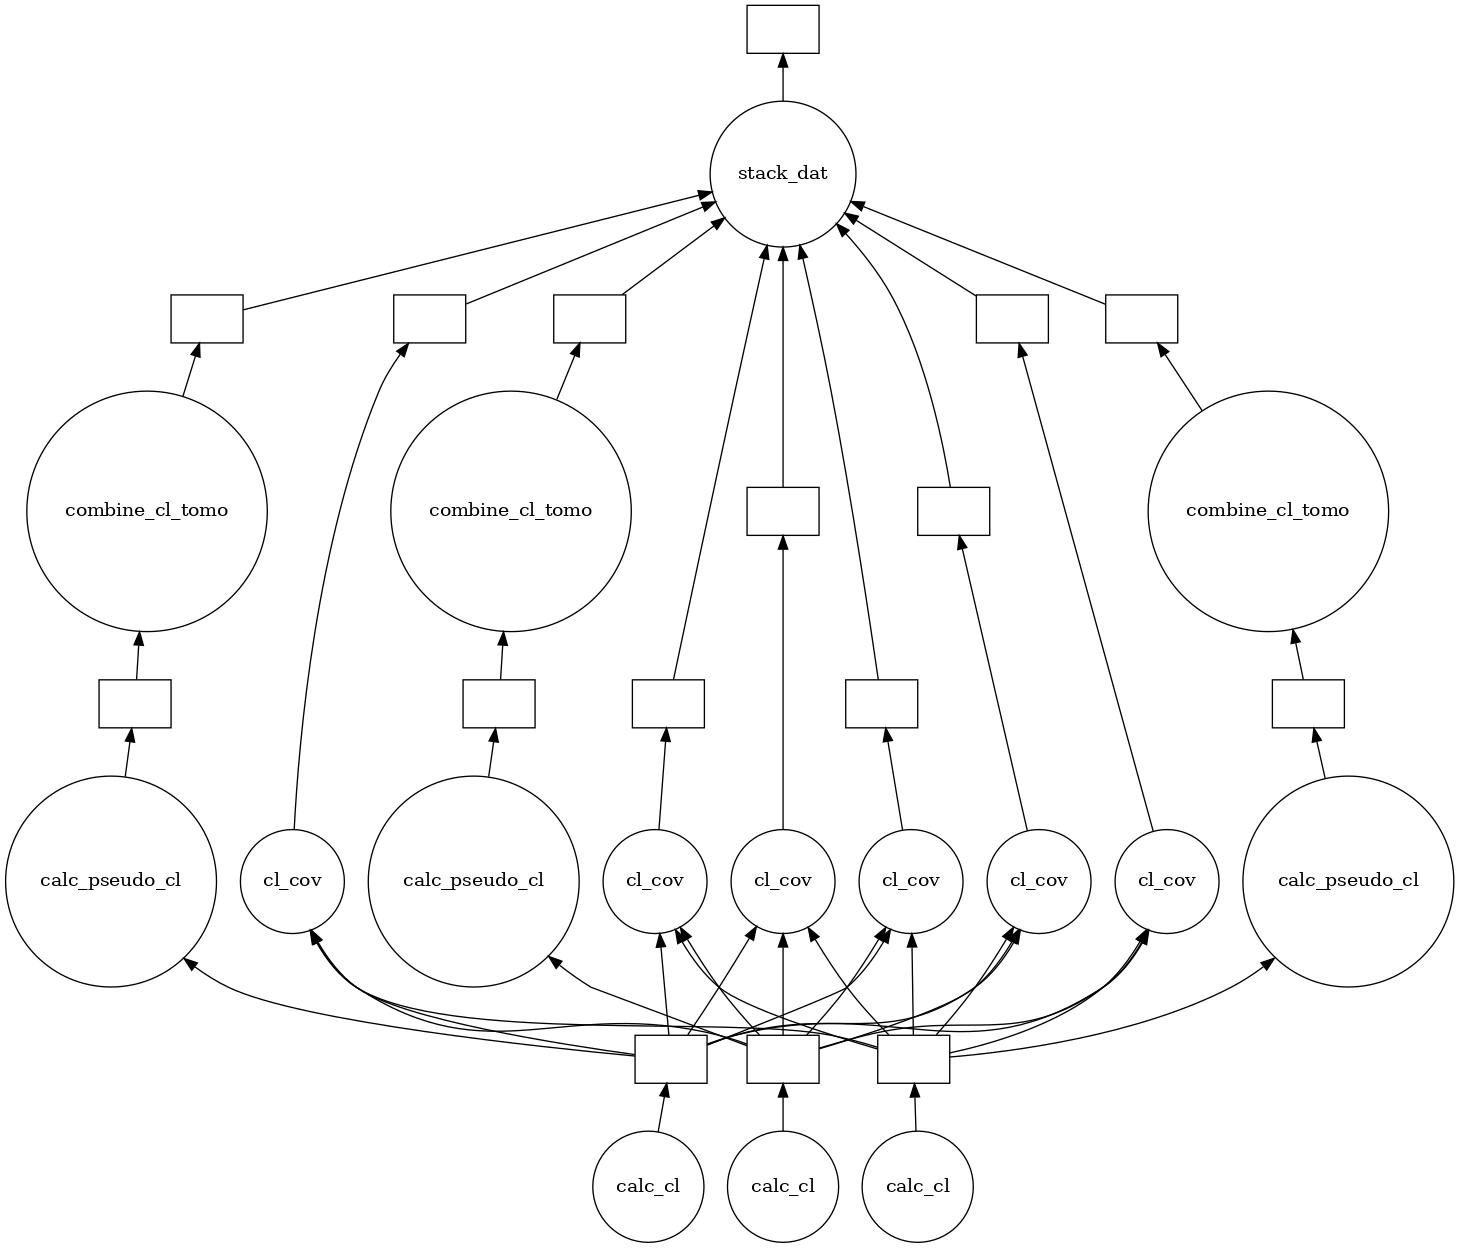

In [34]:
clG['stack'].visualize()

In [35]:
%time cl_L=clG['stack'].compute()

1324 13 24
1423 14 23
1324 13 24
1324 13 24
1423 14 23
1423 14 23
1324 13 24
1423 14 23
1324 13 24
1324 13 24
1423 14 23
1423 14 23
CPU times: user 1.53 s, sys: 71.6 ms, total: 1.6 s
Wall time: 1.33 s


In [36]:
cl=clG['cl'][corr_ll][bi].compute()
pcl=clG['cl_b'][corr_ll][bi].compute()

In [37]:
lb=0.5*(XI_W_L.l_bins[1:]+XI_W_L.l_bins[:-1])

[]

02:06:41 WARNING:findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


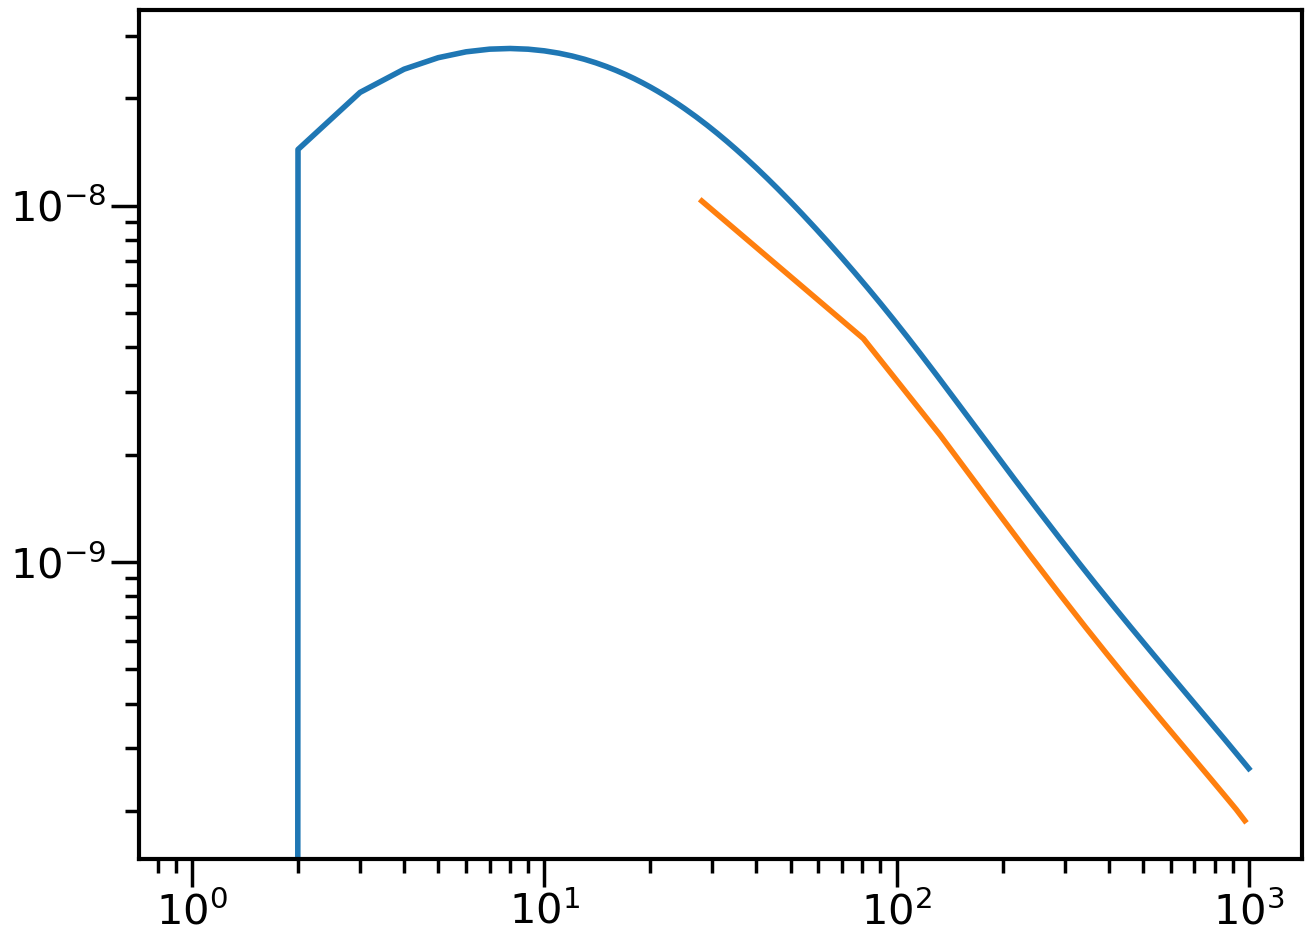

In [38]:
plot(XI_W_L.l,cl)
plot(lb,pcl)
loglog()

In [39]:
A=np.int8(np.eye(1000))
X=np.float32(np.eye(1000))

In [40]:
A

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int8)

In [41]:
B=A.astype('bool')

In [42]:
%time x1=X*A
%time x2=X*B

CPU times: user 3.59 ms, sys: 269 µs, total: 3.86 ms
Wall time: 3.85 ms
CPU times: user 0 ns, sys: 2.41 ms, total: 2.41 ms
Wall time: 1.46 ms


In [43]:
np.all(x1==x2)

True

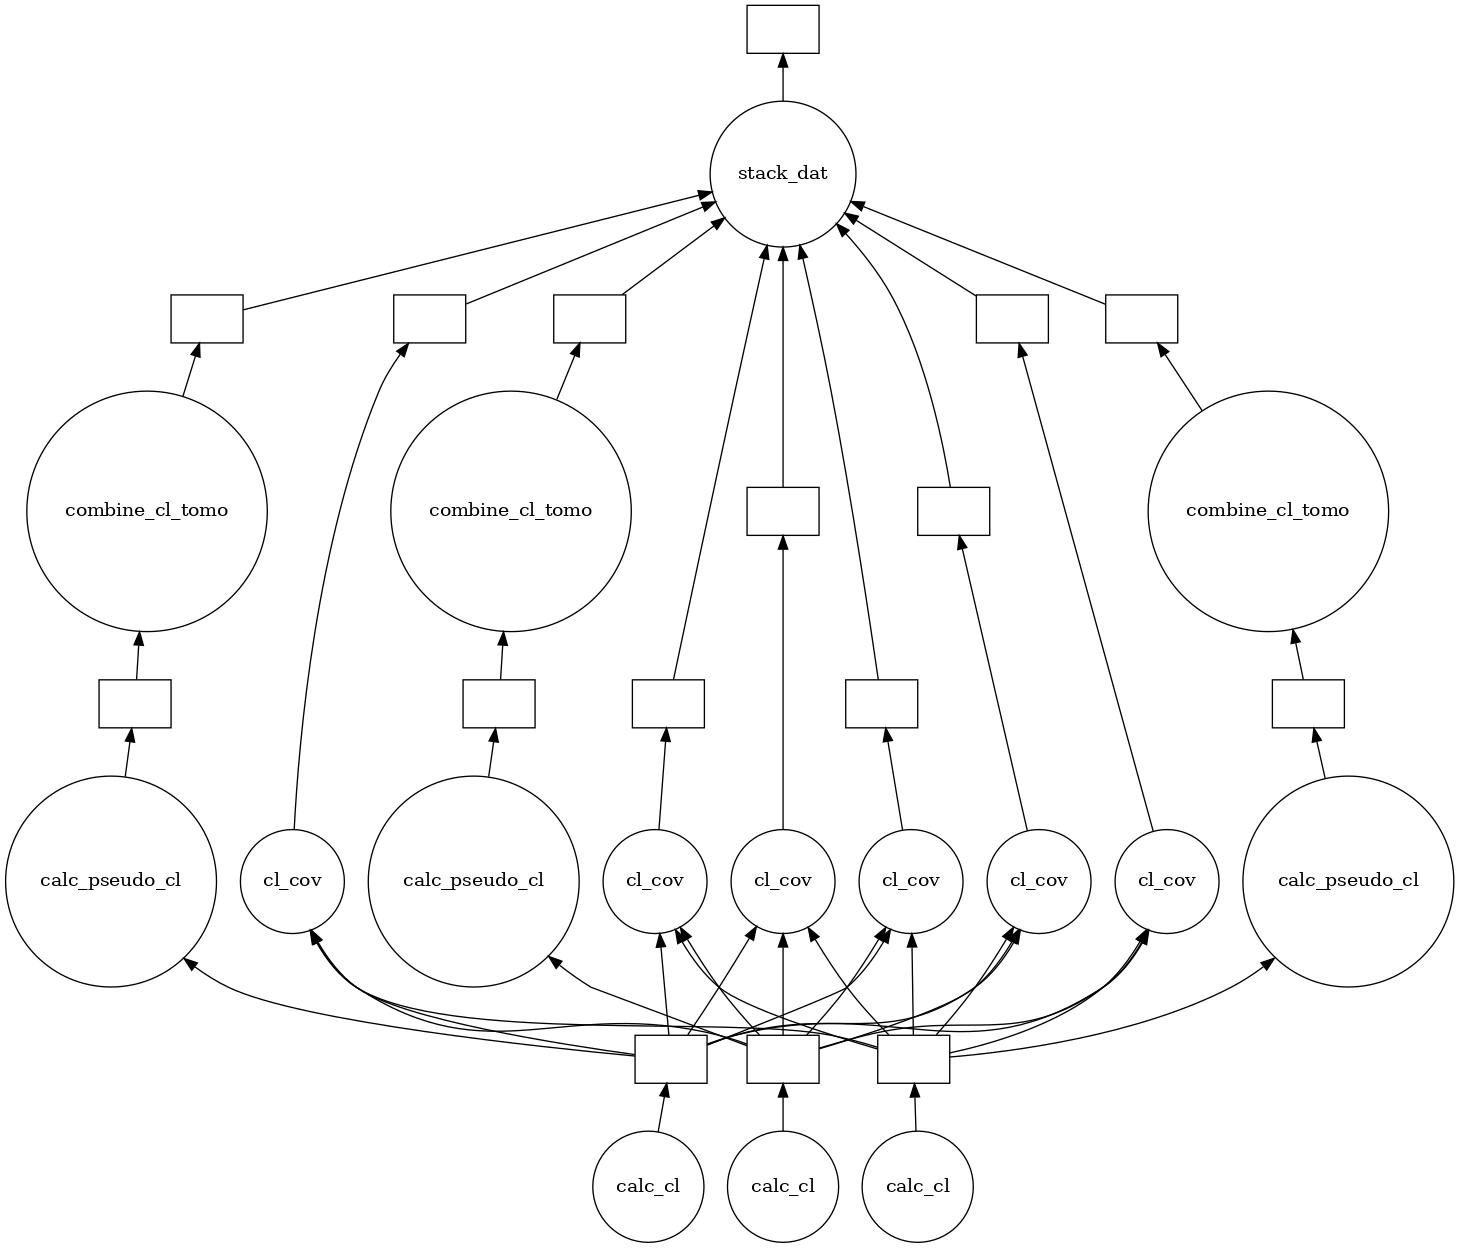

In [44]:
dask.visualize(clG['stack'])

In [45]:
np.arange(1000,step=300)

array([  0, 300, 600, 900])

In [46]:
XI_W_L.Win.Win['cl'][corr_ll][bi]

{'corr': ('shear', 'shear'),
 'indxs': (0, 0),
 'cl': array([6.15746550e+00, 5.54182875e-01, 8.86680731e-02, 1.38670174e-03,
        1.95871942e-02, 4.27230043e-03, 1.51312322e-03, 4.37305093e-03,
        3.30071108e-04, 1.15243898e-03, 1.34382903e-03, 3.40176101e-07,
        7.87217755e-04, 4.08090992e-04, 6.26615058e-05, 4.90237393e-04,
        9.31221594e-05, 1.29637332e-04, 2.72453570e-04, 6.62551661e-06,
        1.50367130e-04, 1.28518399e-04, 4.93411729e-06, 1.33561273e-04,
        4.58934732e-05, 2.63529652e-05, 9.77190892e-05, 8.59413921e-06,
        4.43522079e-05, 5.89665691e-05, 1.43399188e-07]),
 'cl_noise': array([6.15746550e+00, 5.54182875e-01, 8.86680731e-02, 1.38670174e-03,
        1.95871942e-02, 4.27230043e-03, 1.51312322e-03, 4.37305093e-03,
        3.30071108e-04, 1.15243898e-03, 1.34382903e-03, 3.40176101e-07,
        7.87217755e-04, 4.08090992e-04, 6.26615058e-05, 4.90237393e-04,
        9.31221594e-05, 1.29637332e-04, 2.72453570e-04, 6.62551661e-06,
        1.503

In [47]:
XI_W_L.Win.Win['cl'][corr_ll][bi]['M_B_noise']

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 8.82561161e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.14768521e-07, 6.50088948e-07, 3.71439995e-07],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.50740666e-07, 9.12937337e-07, 6.48788635e-07],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.72184737e-07, 6.49438399e-07, 9.11111703e-07]])

In [48]:
# M2=XI_W_L.Win.Win['cov'][corr_ll+corr_ll][bi+bi]['M1324'][2].compute()
try:
    M2n=XI_W_L.Win.Win['cl'][corr_ll][bi]['M_B'].compute()
except:
    M2n=XI_W_L.Win.Win['cl'][corr_ll][bi]['M_B']
XI_W_L.SN[corr_ll][:,0,0]@M2n

array([0.00000000e+00, 0.00000000e+00, 3.88874976e-11, 2.73319968e-11,
       1.96765684e-11, 1.61590855e-11, 1.34835982e-11, 1.14336259e-11,
       1.00776349e-11, 8.88522097e-12, 7.94733973e-12, 7.21816568e-12,
       6.54965977e-12, 6.01504963e-12, 5.55394027e-12, 5.13191540e-12,
       4.78484851e-12, 4.46552070e-12, 4.17827693e-12, 3.93220972e-12,
       3.69873319e-12, 3.49192460e-12, 3.30642699e-12, 3.12967581e-12,
       2.97361703e-12, 2.82787023e-12, 2.69062167e-12, 2.56797477e-12,
       2.45037987e-12, 2.34142210e-12, 2.24171879e-12, 2.14524487e-12,
       2.05248328e-12, 1.96370962e-12, 1.87904315e-12, 1.79849449e-12,
       1.72199999e-12, 1.64944643e-12, 1.58068868e-12, 1.51556224e-12,
       1.45389230e-12, 1.39550015e-12, 1.34020753e-12, 1.28783971e-12,
       1.23822761e-12, 1.19120902e-12, 1.14662942e-12, 1.10434235e-12,
       1.06420951e-12, 1.02610082e-12, 9.89894047e-13, 9.55474667e-13,
       9.22735428e-13, 8.91576027e-13, 8.61902727e-13, 8.33627939e-13,
      

[]

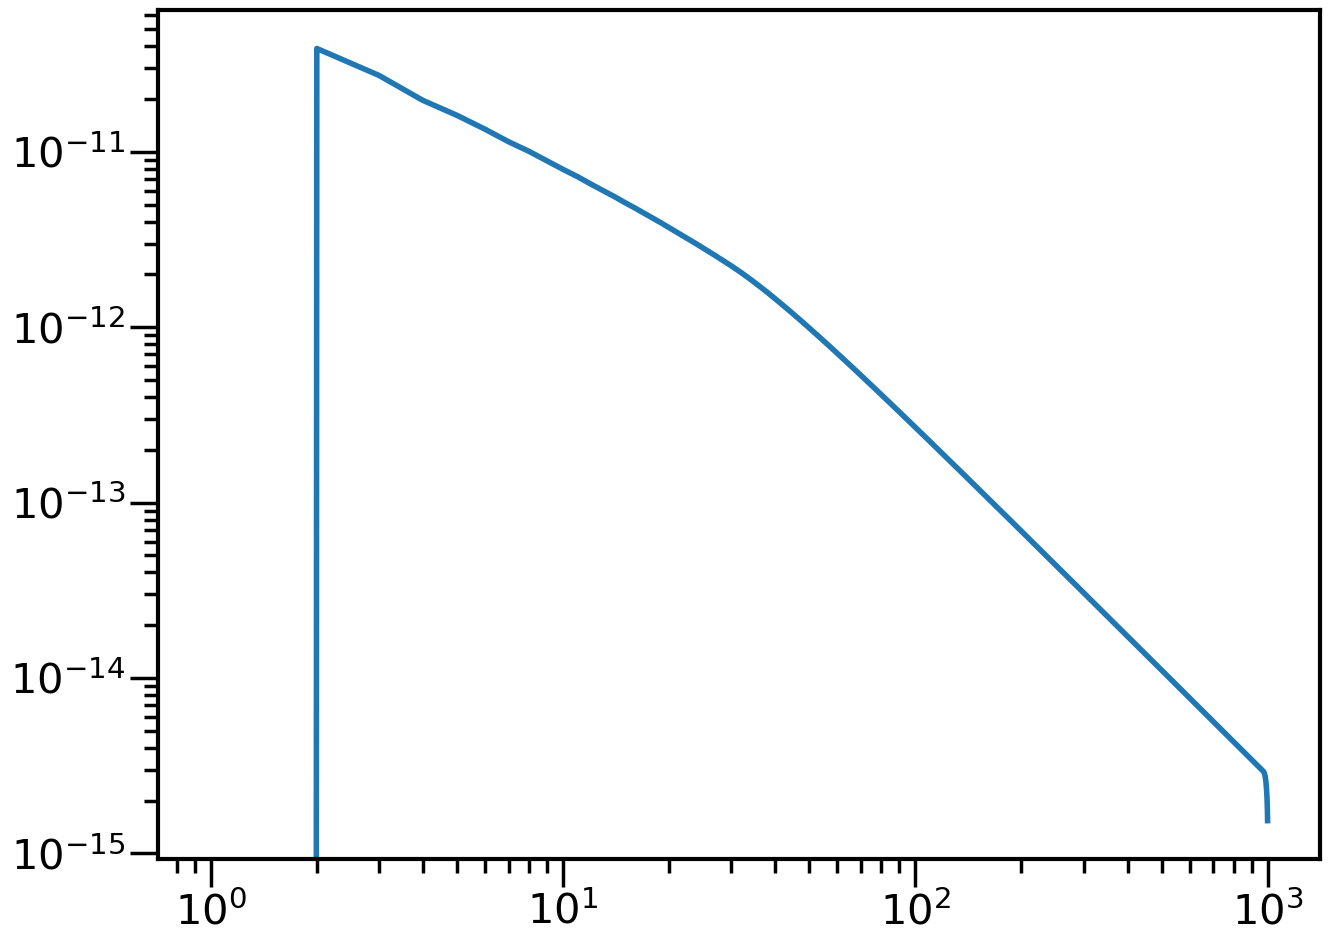

In [49]:
bi=(0,0)
f=1#XI_W_L.l**2
# plot(XI_W_L.l,f*(XI_W_L.SN[corr_ll][:,0,0]@XI_W_L.Win.Win['cov'][corr_ll+corr_ll][bi+bi]['M1324'][2]))
plot(XI_W_L.l,f*(XI_W_L.SN[corr_ll][:,0,0]@M2n))
loglog()

In [50]:
xx=np.random.uniform(0,1,size=(1000,100,3000,)).astype('float64')
xx2=xx.reshape(100,3000,1000)
xx3=xx2.astype('int8')
A=np.ones(1000)

In [51]:
A2=np.int32(A)

In [52]:
XI_W_L_NW= cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,zg_bins=zl_bins, #no window
                do_sample_variance=do_sample_variance,use_window=False,window_lmax=window_lmax,
                power_spectra_kwargs=power_spectra_kwargs,corrs=[corr_ll,corr_ggl,corr_gg],store_win=True,
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,HT=WT_L,f_sky=f_sky,
               bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)
print('NW done')

./cov_utils.py:60: RuntimeWarning: invalid value encountered in true_divide
  Win0=2*jn(1,l_th)/l_th
./angular_power_spectra.py:23: RuntimeWarning: divide by zero encountered in true_divide
  self.cl_f=(l+0.5)**2/(l*(l+1.)) # cl correction from Kilbinger+ 2017


corr_indxs {('shear', 'shear'): [(0, 0)], ('galaxy', 'galaxy'): [(0, 0)], ('kappa', 'kappa'): [], ('shear', 'galaxy'): [(0, 0)], ('galaxy', 'shear'): [(0, 0)]}
Win gen: step size 1001
NW done


In [53]:
# %time clG=XI_W_L.cl_tomo()
%time clG_nw=XI_W_L_NW.cl_tomo()
#%time clH=XI_H.cl_tomo()

added extra corr calc for covariance [('shear', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('galaxy', 'shear')]
Note: redshifts have been re-sorted (earliest first)


/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


cl dict done
CPU times: user 3.12 s, sys: 24.2 ms, total: 3.15 s
Wall time: 1.25 s


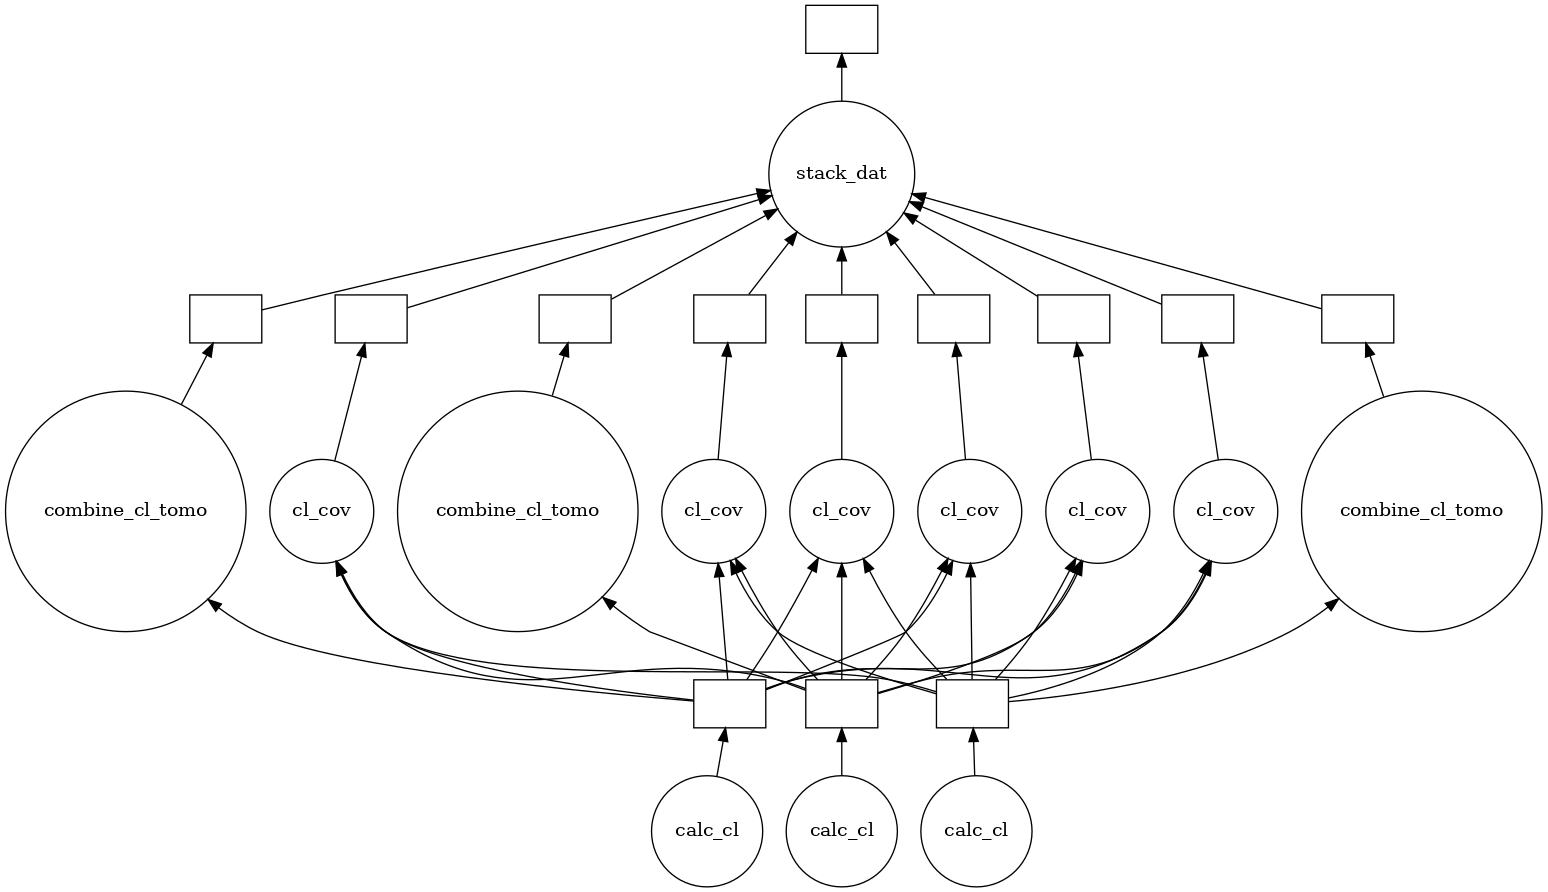

In [54]:
clG_nw['stack'].visualize()

In [55]:
%time cl_L_nw=clG_nw['stack'].compute()

CPU times: user 805 ms, sys: 43.6 ms, total: 848 ms
Wall time: 534 ms


In [56]:
clG['cl'].keys()

dict_keys([('shear', 'shear'), ('galaxy', 'galaxy'), ('shear', 'galaxy'), ('galaxy', 'shear')])

In [57]:
bi=(0,0)
corr=corr_ggl
cov_t=clG['cov'][corr+corr][(0,0,0,0)].compute()
cl_bt=clG['cl_b'][corr][(0,0)].compute()
cl_btnw=clG_nw['cl_b'][corr][(0,0)].compute()
cov_tnw=clG_nw['cov'][corr+corr][(0,0,0,0)].compute()

1324 13 24
1423 14 23


[]

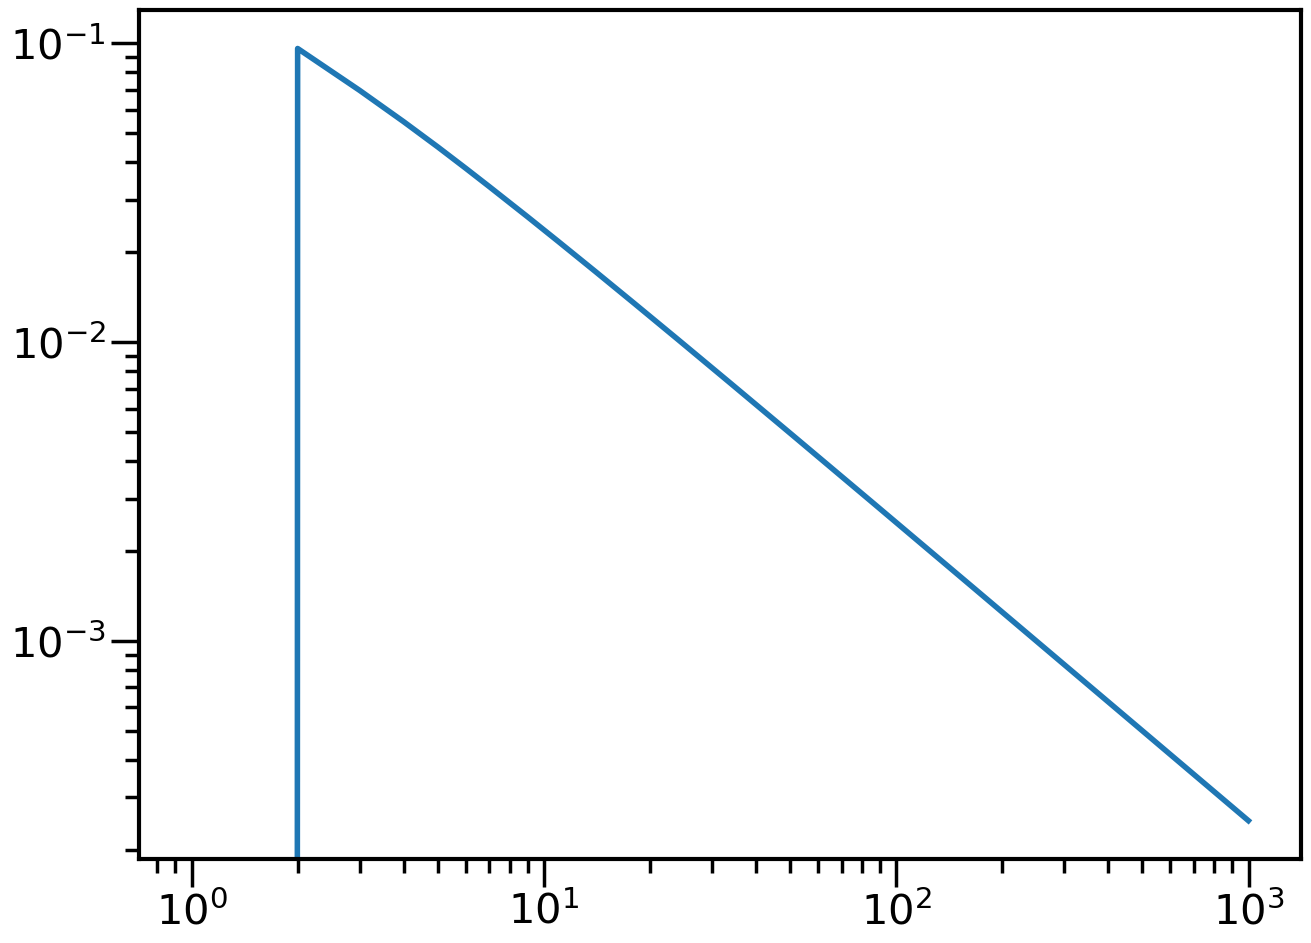

In [58]:
nn='G1324'
plot(np.diag(cov_t[nn])/np.diag(cov_tnw[nn]))
loglog()

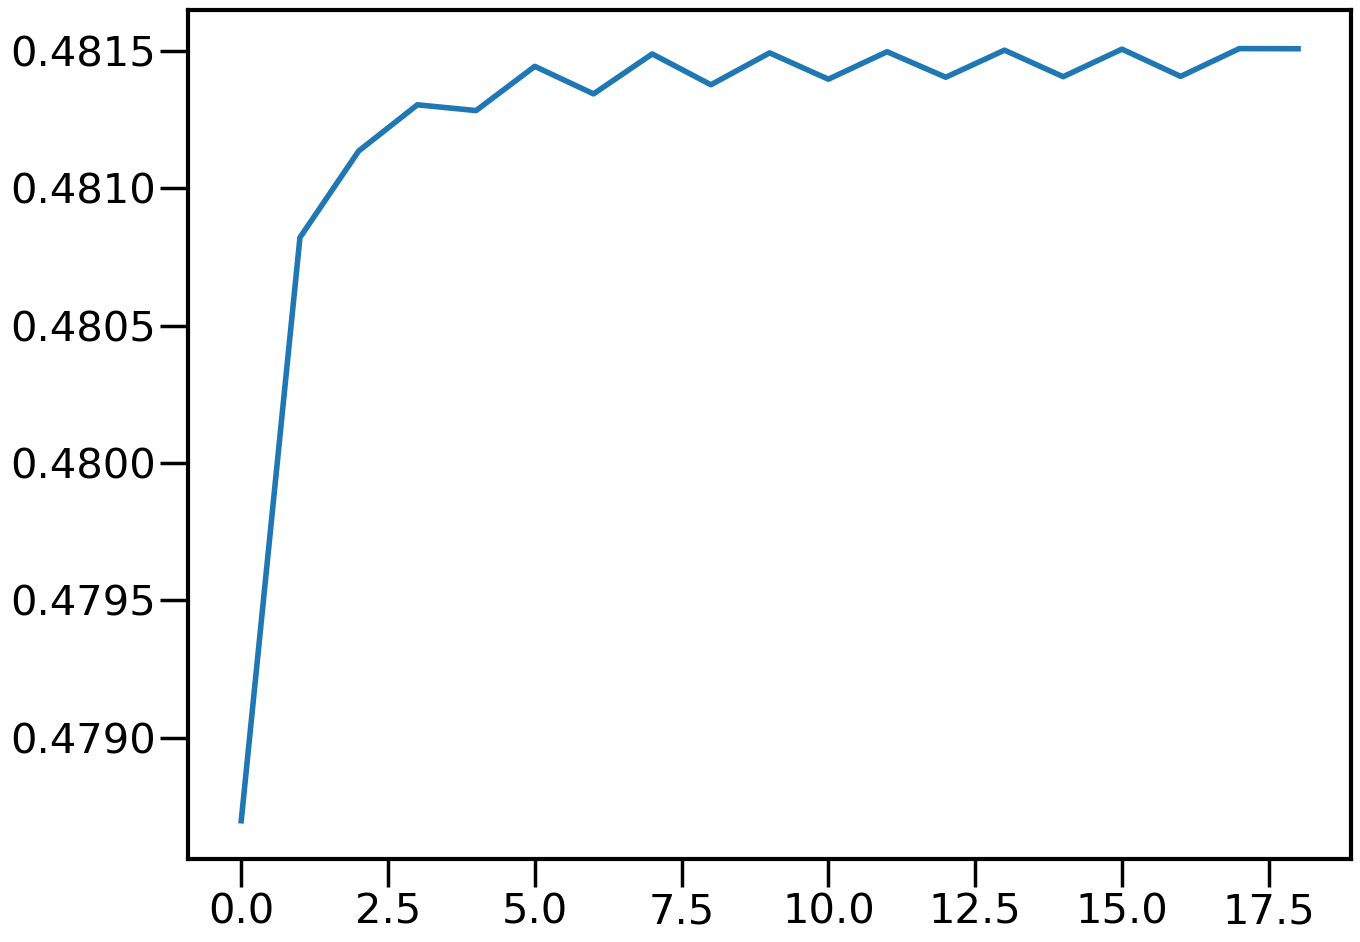

In [59]:
plot(np.diag(cov_t['final_b'])/np.diag(cov_tnw['final_b']))
# loglog()

In [60]:
crash

NameError: name 'crash' is not defined

In [ ]:
plot(np.diag(cov_t['final_b']))
plot(cl_bt**2)
plot(np.diag(cov_tnw['final_b']),':')
plot(cl_btnw**2,':')
loglog()

In [ ]:
cc=XI_W_L.cov_utils
corrW=cc.corr_matrix(cov_t['final_b'])
corrW-=np.diag(np.diag(corrW))
pcolor(corrW,vmin=-.1,vmax=.1,cmap='seismic')
xticks([])
yticks([])
colorbar()
show()



In [ ]:
cc=XI_W_L.cov_utils
corrW=cc.corr_matrix(cl_L_nw['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
xticks([])
yticks([])
colorbar()
show()


In [ ]:
XI_W_L.Win.Win['cov'][(corr_ll+corr_ll)][bi+bi]['Om_w'],XI_W_L_NW.cov_utils.Om_W

In [ ]:
plot(XI_W_L.Win.Win['cov'][(corr_ll+corr_ll)][bi+bi]['mask_comb_cl'])
plot(XI_W_L_NW.cov_utils.Win)
yscale('log')

In [ ]:
XI_W_L.Win.Win['cov'][corr_ll+corr_ll][bi+bi]['mask_comb_cl']

In [ ]:
XI_W_L_NW.f_sky

In [ ]:
XI_W_L_NW.cov_utils.Win

In [ ]:
cc=XI_W_L.cov_utils
corrW=cc.corr_matrix(cl_L['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Wigner')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
linalg.cond(cl_L['cov']) #< 1/sys.float_info.epsilon

In [ ]:
N=np.linalg.norm(cl_L['cov'])
np.linalg.det(cl_L['cov']*5.e20)

In [ ]:
cov_inv=np.linalg.inv(cl_L['cov'])
cov_nw_inv=np.linalg.inv(cl_L_nw['cov'])
SN=cl_L['cl_b']@cov_inv@cl_L['cl_b']
SN_nw=cl_L_nw['cl_b']@cov_nw_inv@cl_L_nw['cl_b']
SN,SN_nw,SN/SN_nw

In [ ]:
%time xiWG_L=XI_W_L.xi_tomo()
%time xiWG_L_nw=XI_W_L_NW.xi_tomo()

In [ ]:
%time xiW_L=xiWG_L['stack'].compute()
%time xiW_L_nw=xiWG_L_nw['stack'].compute()

In [ ]:
XI_W_L.corrs

In [ ]:
XI_W_L.Win.Win.keys()

In [ ]:
f=1
xiW_L_nw_inv=np.linalg.inv(xiW_L_nw['cov']*f)
print ((np.dot(xiW_L_nw['xi'],np.dot(xiW_L_nw_inv,xiW_L_nw['xi']))))

cov_xiWL_inv=np.linalg.inv(xiW_L['cov']*f)
print ((np.dot(xiW_L['xi'],np.dot(cov_xiWL_inv,xiW_L['xi']))))

In [ ]:
pcolor(xiW_L_nw['cov']/xiW_L['cov'])
colorbar()

In [ ]:
pcolor(xiW_L_nw_inv/cov_xiWL_inv)
colorbar()

In [ ]:
cc=XI_W_L.cov_utils
corrW=cc.corr_matrix(cl_L['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('$C_\ell$')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
cc=XI_W_L.cov_utils
corrW=cc.corr_matrix(cl_L_nw['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('$C_\ell$-NW')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
R=np.diag(cl_L_nw['cov']/cl_L['cov'])
plot(R)

In [ ]:
cc=XI_W_L.cov_utils
corrW=cc.corr_matrix(xiW_L['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Wigner-W')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
cc=XI_W_L.cov_utils
corrNW=cc.corr_matrix(xiW_L_nw['cov'])
pcolor(corrNW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Wigner-NW')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
pcolor(corrW/corrNW-1,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Wigner')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
XI_W_L.cov_utils.gaussian_cov_norm_2D

In [ ]:
np.diag(xiW_L_nw['cov'])/np.diag(xiW_L['cov'])

In [ ]:
5.25/1.93

In [ ]:
x=np.array([1,0.5,0.1,0.3,0.7])
plot(x,[1,1.93,5.25,2.85,1.37],'bo')
plot(x,1./x,'ro')
yscale('log')
xscale('log')

In [ ]:
xiW_L_nw['cov']/xiW_L['cov']

In [ ]:
xiW_L_nw['xi']/xiW_L['xi']